# Time Series Forecasting using Gaussian Process Regression

In [1]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


# Data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
import scipy

# Set font scale and style
plt.rcParams.update({'font.size': 18})

# GPR 
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# import custom class
%run -i '../src/helper/ts.py'

In [3]:
# Instantiate the class
fxn = TimeSeriesForecasting()

# Load  data

In [4]:
ts = pd.read_csv('../data/collision_ts_month.csv') # load data
ts.date = pd.to_datetime(ts['date'])  # convert to datetime
ts.index = ts.date # make date the dataframe index
ts = ts.drop(['date'], axis =1)

print("Data size:", ts.shape)
ts.head()

Data size: (228, 9)


,fatality_rate,med_fatal,med_injury,med_no_injury,not-head-on,head-on,year,month,summer_ind
date,,,,,,,,,
1999-01-01,0.013067,85.0,99.0,48.0,108.0,124.0,1999,1,0
1999-02-01,0.017570,101.0,108.0,40.0,93.0,156.0,1999,2,0
1999-03-01,0.021727,105.0,170.0,48.0,96.0,227.0,1999,3,0
1999-04-01,0.013606,99.0,84.0,32.0,44.0,171.0,1999,4,0
1999-05-01,0.018343,150.0,165.0,53.0,79.0,289.0,1999,5,0


## Create a test  set
We must split the dataset into training and test (out-of-sample) set. We have chosen the test set as the last year's observations (i.e. 2017).

In [5]:
train_start, train_end = '1999-01-01','2016-12-01'
test_start, test_end = '2017-01-01', '2017-12-01'

X_train = ts.drop('fatality_rate', axis =1)[train_start: train_end]
y_train = ts['fatality_rate'][train_start: train_end]

X_test = ts.drop('fatality_rate', axis =1)[test_start: test_end]
y_test = ts['fatality_rate'][test_start: test_end]

## Normalization

In [6]:
# Standardization
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Gaussian Process Regression (GPR)

In [7]:
# Train GPR
kernel = RBF(length_scale = np.ones(X_train.shape[1], )) + WhiteKernel(noise_level=0.5)
gpr = GPR(kernel=kernel, n_restarts_optimizer=0, normalize_y=True, random_state=42)
gpr.fit(X_train_scaled, y_train)

# Make prediction
yhat, std = gpr.predict(X_test_scaled, return_std=True)

## Performance measures (error metrics)

In [8]:
fxn.error_metrics(y_test, yhat)

{'MAE = 0.001', 'MAPE = 5.756', 'RMSE = 0.001', 'R^2 = 0.891', 'WMAPE = 5.339'}

In [9]:
yhat[yhat<0] = 0

ylow = yhat -2*std
ylow[ylow<0] = 0

yhigh = yhat + 2*std
yhigh[yhigh<0] = 0

results = pd.DataFrame()
results['yhat'] = yhat
results['ylow'] = ylow
results['yhigh'] = yhigh
results.index = y_test.index

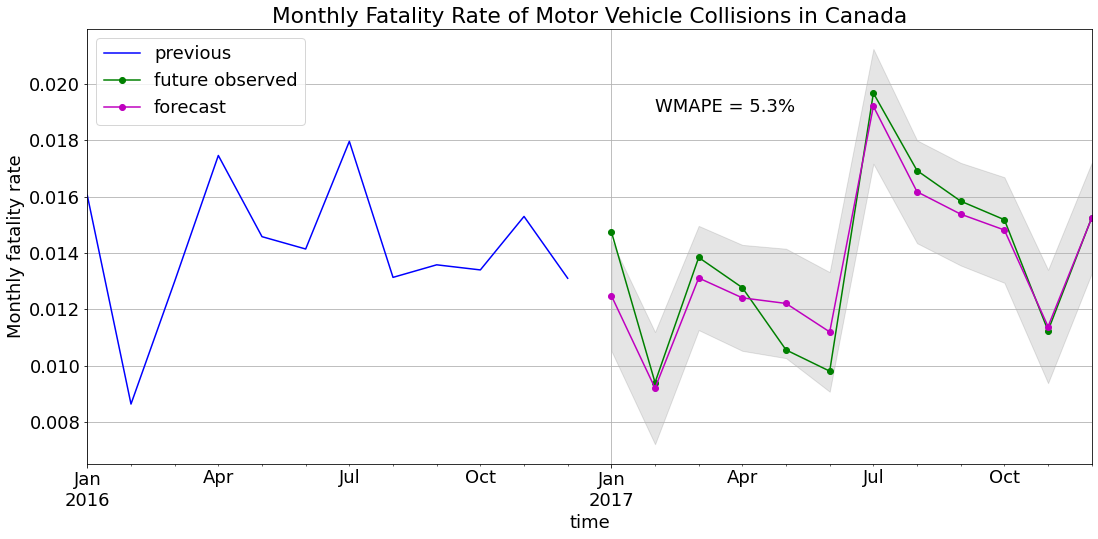

In [12]:
plt.figure(figsize = (18,8))

y_train.iloc[-len(y_test):].plot(label = 'previous', color = 'b')
y_test.plot(label = 'future observed', marker = 'o', color = 'g')
results['yhat'].plot(label = 'forecast', marker = 'o', color = 'm')

plt.fill_between(results.index, results['ylow'], results['yhigh'], color='k', alpha=0.1)
plt.xlabel('time')
plt.text('2017-02-01', 0.019, "WMAPE = 5.3%")
plt.grid(True)
plt.ylabel('Monthly fatality rate')
plt.title('Monthly Fatality Rate of Motor Vehicle Collisions in Canada')
plt.legend()
plt.savefig('../images/gpr.png')
plt.show()

## Test set error

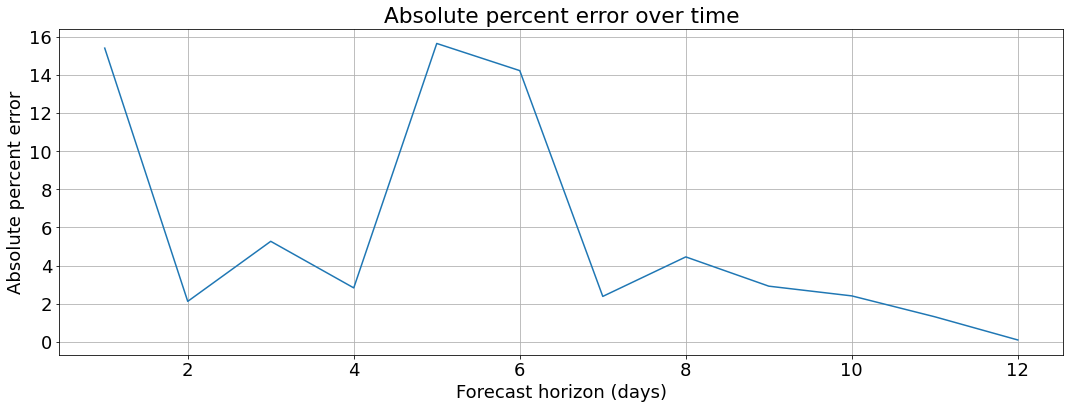

In [11]:
plt.figure(figsize = (18,6))
abs_err = 100*np.abs((yhat - y_test.values)/(y_test.values))

plt.plot(np.arange(1, len(abs_err)+1), abs_err)
plt.grid(True)
plt.xlabel('Forecast horizon (days)')
plt.ylabel('Absolute percent error')
plt.title('Absolute percent error over time')
plt.show()